In [1]:
import torch
torch.manual_seed(17)

## Import

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# cd /content/drive/MyDrive


In [4]:
# ! unzip open.zip

In [5]:
# !pip install -q git+https://github.com/huggingface/transformers.git

In [6]:
# !pip install -q datasets

In [7]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.core.transforms_interface import ImageOnlyTransform,DualTransform
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from glob import glob
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

In [9]:
id2label = {
    0:'background',
    1:'Load',
    2:'Sidewalk',
    3:'Construction',
    4:'Fence',
    5:'Pole',
    6:'Traffic Light',
    7:'Traffic Sign',
    8:'Nature',
    9:'Sky',
    10:'Person',
    11:'Rider',
    12:'Car',
    13:'Background',
}
id2label_check = {
    0:'background',
    1:'Load',
    2:'Sidewalk',
    3:'Construction',
    4:'Fence',
    5:'Pole',
    6:'Traffic Light',
    7:'Traffic Sign',
    8:'Nature',
    9:'Sky',
    10:'Person',
    11:'Rider',
    12:'Car',
    13:'background_car'
}
label2id = {id2label[x]:x for x in id2label}
label2id

{'background': 0,
 'Load': 1,
 'Sidewalk': 2,
 'Construction': 3,
 'Fence': 4,
 'Pole': 5,
 'Traffic Light': 6,
 'Traffic Sign': 7,
 'Nature': 8,
 'Sky': 9,
 'Person': 10,
 'Rider': 11,
 'Car': 12,
 'Background': 13}

## Utils

In [10]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, image_path:list,mask_path:list, transform=None, infer=False):
        self.transform = transform
        self.infer = infer
        self.img_path=image_path
        self.mask_path=mask_path
        self.key_path= {"train_fishimage":"train_source_image","train_maskimg":"train_source_gt","val_fishimage":"val_source_image","val_maskimg":"val_source_gt"}
    def __len__(self):
        # return len(self.data)
        return len(self.img_path)
    
    def __getitem__(self, idx):
        choice = np.random.randint(10)
        img_path = self.img_path[idx]
        if choice < 4:
            train_val,file_name = img_path.split('/')[1:]
            img_path = f"./{self.key_path[train_val]}/{file_name}"
            # print(img_path)
        image = cv2.imread(f"{img_path}")
        ori_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=ori_image)['image']
            return image,ori_image
        mask_path = self.mask_path[idx]
        if choice < 4:
            train_val,file_name = mask_path.split('/')[1:]
            mask_path = f"./{self.key_path[train_val]}/{file_name}"
        # print(mask_path)
        ori_mask = cv2.imread(f"{mask_path}", cv2.IMREAD_GRAYSCALE)
        if 'source' in mask_path:
            ori_mask[ori_mask==255]=12
            ori_mask+=1
        if self.transform:
            augmented = self.transform(image=ori_image, mask=ori_mask)
            image = augmented['image']
            mask = augmented['mask']
            if mask.size()==0 or image.size()==0:
                print("ERROR READ IMAGE FAILE")
        return image, mask ,ori_image,ori_mask

In [12]:
import matplotlib.pyplot as plt
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255
# jitter = A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1,always_apply=False,p=0.2)

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(width=960,height=540),
    # A.PiecewiseAffine(p=0.5),
    A.RandomToneCurve(p=1),
    # A.Rotate(limit=45,interpolation=cv2.BORDER_CONSTANT,value=255,p=0.4),
    ToTensorV2()
])

In [13]:
import os

In [14]:
t = glob("*")
t

['fish_transform copy.ipynb',
 'mask.png',
 'train_source.csv',
 'train_target.csv',
 'sub.ipynb',
 'val_source_fish.csv',
 'train_maskimg',
 'last_epoch3',
 'fish_transform.ipynb',
 'test.csv',
 'best_model_base',
 'sample_submission.csv',
 'train_source_image',
 'last_epoch_base3',
 'last_epoch_base',
 'best_model_base2',
 'mask3former.ipynb',
 'train_target_image',
 'val_maskimg',
 'baseline_submit.csv',
 'train_source_gt',
 'train_fishimage',
 'val_source_gt',
 'albumentation_test.ipynb',
 'test_image',
 'last_epoch_base2',
 'new',
 'nohup.out',
 'val_source.csv',
 'val_fishimage',
 'val_source_image',
 'data2.pickle',
 'c20180354_new',
 'train_source_fish.csv',
 'test.ipynb',
 'source.jpg',
 'SDFSD',
 'mask2former.ipynb',
 'best_model_base3']

In [15]:
img_path  = glob("./*_fishimage/*.png") 
mask_path = glob("./*_maskimg/*.png") 
correct = 0
# img_path2 = glob("./*_source_image/*.png")
# mask_path2 = glob("./*_source_gt/*.png")

for x,y in zip(img_path,mask_path):
    if x.split('_')[-1].split('.')[0]==y.split('_')[-1].split('.')[0]:
        correct+=1
print("correct :",correct)
# for x,y in zip(img_path2,mask_path2):
#     if x.split('_')[-1].split('.')[0]==y.split('_')[-1].split('.')[0]:
#         correct+=1
# print("correct :",correct)
print(len(img_path),len(mask_path))
valid_img_path = []
valid_mask_path = []
all_image_path = [] 
all_mask_path = []

for im_p,ma_p in zip(img_path,mask_path):
    mask = cv2.imread(f'{ma_p}', cv2.IMREAD_GRAYSCALE)
    if np.any(mask==11) or np.any(mask==10) or np.any(mask==5):
        valid_img_path.append(im_p)
        valid_mask_path.append(ma_p)
    else:
        all_image_path.append(im_p)
        all_mask_path.append(ma_p)

# for im_p,ma_p in zip(img_path2,mask_path2):
#     mask = cv2.imread(f'{ma_p}', cv2.IMREAD_GRAYSCALE)
#     if np.any(mask==10) or np.any(mask==9) or np.any(mask==4):
#         valid_img_path.append(im_p)
#         valid_mask_path.append(ma_p)

len(valid_img_path),len(valid_mask_path) , len(all_image_path) , len(all_mask_path)

correct : 2660
2660 2660


(2336, 2336, 324, 324)

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(2)
valid_img_path = np.array(img_path)
valid_mask_path = np.array(mask_path)
size_path = int(len(valid_img_path)*0.95)
s1 = np.arange(len(valid_img_path))
np.random.shuffle(s1)
train, valid = s1[:size_path], s1[size_path:]
train_img_path = valid_img_path[train]
train_mask_path = valid_mask_path[train]
#  
valid2_img_path = valid_img_path[valid]
valid2_mask_path = valid_mask_path[valid]
# valid2_mask_path = traivalid2_mask_pathn_test_split(valid_img_path,valid_mask_path,test_size=0.1,random_state=64,shuffle=True)


In [17]:
# valid2_img_path, test_img_path,valid2_mask_path,test_mask_path = train_test_split(test_img_path,test_mask_path,test_size=0.5,random_state=64,shuffle=False)

In [18]:
# origin_img_path = glob('./val_source_image/*png')
# origin_mask_path = glob('./val_source_gt/*png')


In [19]:
# valid2_img_path =  np.concatenate((valid2_img_path ,np.array(origin_img_path[:200])))
# valid2_mask_path = np.concatenate((valid2_mask_path ,np.array(origin_mask_path[:200])))
# valid2_mask_path = np.array(valid2_mask_path)
# valid2_img_path = np.array(valid2_img_path)
np.random.seed(12)
# random.seed(26)
s = np.arange(len(valid2_img_path))
np.random.shuffle(s)
valid2_img_path = valid2_img_path[s]
valid2_mask_path = valid2_mask_path[s]
train_dataset = CustomDataset(train_img_path,train_mask_path,transform=train_transform)
valid_dataset = CustomDataset(valid2_img_path,valid2_mask_path,transform=test_transform)
# test_dataset = CustomDataset()
len(train_dataset),len(valid_dataset)

(2527, 133)

In [20]:
# all_dataset = CustomDataset(img_path,mask_path,transform=train_transform)

In [21]:
correct = 0
for x,y in zip(train_img_path,train_mask_path):
    if x.split('_')[-1].split('.')[0]==y.split('_')[-1].split('.')[0]:
        correct+=1
print("correct :",correct)

correct = 0
for x,y in zip(valid2_img_path,valid2_mask_path):
    if x.split('_')[-1].split('.')[0]==y.split('_')[-1].split('.')[0]:
        correct+=1
print("correct :",correct)

correct : 2527
correct : 133


## Data Loader

In [22]:
# import pickle
# with open('../data2.pickle','rb') as fr:
#     data = pickle.load(fr)

In [23]:
# def distortion(img):
#     img[img==255]=12
#     img  +=1
#     img =cv2.remap(img,data['map_x'],data['map_y'],interpolation=cv2.INTER_NEAREST)
#     return img

In [24]:
# class BarrelDistortion(DualTransform):
#     def __init__(
#         self,
#         always_apply=False,
#         p=1
#  ):
#         super(BarrelDistortion, self).__init__(always_apply, p)
#     def apply(self, img, **params):
#         return distortion(img)

## Transform

In [25]:
# ! pip install --upgrade pip setuptools wheel

# Transform Train to FishEye


In [26]:
# ! pip install transformers

In [27]:
# ! pip install accelerate -U

In [28]:
from transformers import Mask2FormerImageProcessor
from transformers import Mask2FormerForUniversalSegmentation
from transformers import AutoImageProcessor
# # Replace the head of the pre-trained custom
# ## 큰모델 사용안했음 :facebook/maskformer-swin-large-ade
# model_check_point = 'facebook/maskformer-swin-base-ade
# # checkpoint_9
# model_checkpoint = 'facebook/mask2former-swin-base-IN21K-cityscapes-semantic'
model_checkpoint = 'facebook/mask2former-swin-large-cityscapes-semantic'

model = Mask2FormerForUniversalSegmentation.from_pretrained(model_checkpoint,id2label=id2label,label2id=label2id,
                                                          ignore_mismatched_sizes=True
                                                          )
# model = Mask2FormerForUniversalSegmentation.from_pretrained(model_checkpoint,ignore_mismatched_sizes=True)
preprocessor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
preprocessor2 = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")



Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-cityscapes-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([20]) in the checkpoint and torch.Size([15]) in the model instantiated
- class_predictor.weight: found shape torch.Size([20, 256]) in the checkpoint and torch.Size([15, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([20]) in the checkpoint and torch.Size([15]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# model.config

In [30]:
## 576

In [31]:
preprocessor.size = {
    "height": 784,
    "width": 784
}
preprocessor2.size = {
    "height": 540,
    "width": 960
}
# preprocessor.ignore_index = 255

In [32]:
model.class_predictor.weight , model.class_predictor.bias ,model.class_predictor,model.criterion.empty_weight

(Parameter containing:
 tensor([[ 0.0244, -0.0581,  0.0450,  ..., -0.0431, -0.0217, -0.0596],
         [ 0.0480, -0.0363, -0.0452,  ..., -0.0221, -0.0285, -0.0388],
         [-0.0101,  0.0448, -0.0011,  ...,  0.0600, -0.0518, -0.0563],
         ...,
         [-0.0248, -0.0588,  0.0477,  ..., -0.0134, -0.0571,  0.0026],
         [-0.0601,  0.0499, -0.0363,  ...,  0.0595,  0.0169, -0.0381],
         [ 0.0292,  0.0247, -0.0609,  ..., -0.0386,  0.0185, -0.0534]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0532, -0.0182, -0.0363, -0.0539, -0.0604,  0.0591,  0.0072, -0.0203,
          0.0370,  0.0301,  0.0277, -0.0571, -0.0031, -0.0296, -0.0542],
        requires_grad=True),
 Linear(in_features=256, out_features=15, bias=True),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.1000]))

In [33]:
la = 0
for layer in model.base_model.parameters():
    la+=1
print(la)
la = 0
for layer in model.parameters():
    la+=1
print(la)

755
757


In [34]:
for layer in model.base_model.parameters():
    layer.requires_grad=False
# len(model.base_model.parameters()), len(model.parameters)

In [35]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    
    batch = preprocessor.preprocess(
        images,
        segmentation_maps=segmentation_maps,
        ignore_index=255,
        return_tensors="pt",
    )
    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch
    
def collate_fn_test(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    
    batch = preprocessor2.preprocess(
        images,
        segmentation_maps=segmentation_maps,
        ignore_index=255,
        return_tensors="pt",
    )
    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

In [36]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(valid_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn_test)

In [37]:
len(train_dataset),len(train_dataloader)

(2527, 79)

# shape 결과

In [38]:
# import torch
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([32, 3, 800, 800])
pixel_mask torch.Size([32, 800, 800])
mask_labels torch.Size([13, 800, 800])
class_labels torch.Size([13])
original_images (1024, 2048, 3)
original_segmentation_maps (1024, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AxesImage(size=(800, 800))


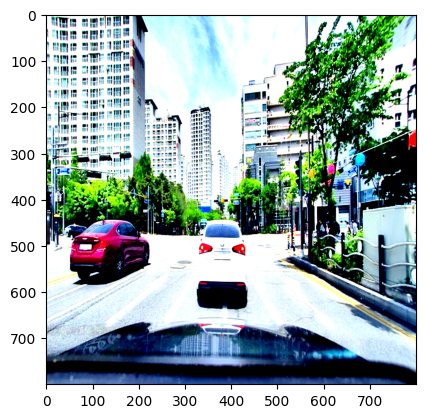

In [39]:
print(plt.imshow(batch['pixel_values'][0].permute(1,2,0).numpy()))

In [40]:
# device = 'cuda'

# with torch.no_grad():
#     outputs = model(batch["pixel_values"],
#       class_labels=batch["class_labels"],
#       mask_labels=batch["mask_labels"]
#     )

# 초기 모델 init loss

In [41]:
# outputs.loss

In [42]:
# print(outputs.loss)

In [43]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    return [[255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255],[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            ]

palette = color_palette()

In [44]:
import matplotlib.pyplot as plt

def checking(batch, predicted_segmentation_maps):
    plt.figure(figsize=(30, 20))
    plt.subplot(3, 1, 1)
    image = batch['original_images'][0]
    # image = batch['pixel_values'][0].permute(1,2,0)
    plt.imshow(image)
    segmentation_map = predicted_segmentation_maps[0].cpu().numpy()
    print("PREDICT : ", np.unique(segmentation_map))
    # print(list(id2label_check[x] for x in np.unique(segmentation_map)))
    color_segmentation_map = np.zeros(
        (segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8)  # height, width, 3
   
    for label, color in enumerate(palette):
        color_segmentation_map[segmentation_map == label, :] = color
    
    ground_truth_color_seg = color_segmentation_map[..., ::-1]

    img = image * 0.5 + ground_truth_color_seg * 0.5
    img = img.astype(np.uint8)

    plt.subplot(3, 1, 2)
    plt.imshow(img)

    segmentation_map = batch["original_segmentation_maps"][0]

    print("Ground Truth : ", np.unique(segmentation_map))
    # print(list(id2label_check[x] for x in np.unique(segmentation_map)))
    color_segmentation_map = np.zeros(
        (segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8)  # height, width, 3
    for label, color in enumerate(palette):
        color_segmentation_map[segmentation_map == label, :] = color

    ground_truth_color_seg = color_segmentation_map[..., ::-1]
    img = image * 0.5 + ground_truth_color_seg * 0.5
    img = img.astype(np.uint8)
    plt.subplot(3, 1, 3)
    plt.imshow(img)
    plt.show()


In [45]:

# original_images = batch["original_images"]
# target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
# predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)


In [46]:
# checking(batch,predicted_segmentation_maps)

In [47]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [48]:
# ! pip install  evaluate

In [49]:
import evaluate
metric = evaluate.load("mean_iou")

In [50]:
before_miou=None

In [51]:
# ! pip3 install --upgrade ipywidgets
# ! jupyter nbextension enable --py widgetsnbextension

In [52]:
# import torch
from tqdm.auto import tqdm
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
find = glob("last_epoch_base3")
if not find:
  model.to(device)

  # # 논문에서는 0.0001 ,wd =  0.05 사용
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-3,weight_decay=0.05)
  # model_start_idx = int(model_name.split('_')[2])+1
  running_loss = 0.0
  num_samples = 0
  accumulation_steps = 2
  total_batch=  len(train_dataloader)
  error_count= 0
  for epoch in range(3):
    print("Epoch:", epoch)
    model.train()
    avg_cost = 0
    # model.zero_grad()   
    for idx in tqdm(range(len(train_dataloader))):
      try:
          batch = next(iter(train_dataloader))
      except Exception as e:
          print(e)
          error_count +=1
          # batch = next(iter(train_dataloader))
          pass
      # Reset the parameter gradients
      optimizer.zero_grad()
      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]]
      )
      # Backward propagation
      loss = outputs.loss
      loss = loss/accumulation_steps
      loss.backward()
      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size
      if (idx+1)%accumulation_steps==0:
        optimizer.step()
        model.zero_grad()
        avg_cost += loss / total_batch
      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)
    print(f'[Epoch:{epoch}] cost = {avg_cost}')
        # Optimization
    model.eval()
    # model.zero_grad() 
    for idx in tqdm(range(len(test_dataloader))):
      try:
          batch = next(iter(test_dataloader))
      except Exception as e:
          print(e)
          error_count +=1
          # batch = next(iter(test_dataloader))
          pass
      pixel_values = batch["pixel_values"]

      # Forward pass
      with torch.no_grad():
        outputs = model(pixel_values=pixel_values.to(device))

      # get original images
      original_images = batch["original_images"]
      target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
      # predict segmentation maps
      predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                    target_sizes=target_sizes)
      # get ground truth segmentation maps
      ground_truth_segmentation_maps = batch["original_segmentation_maps"]
      
      metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
      if idx > 10:
        break
    current = metric.compute(num_labels = len(id2label),ignore_index=0,reduce_labels=False)
    model.save_pretrained('base3')
    print("Mean IoU :", current['mean_iou'])
    print('Mean Acc :',current['mean_accuracy'])
    print('Per Categoric Iou : ',current['per_category_iou'])
    try:
      checking(batch,predicted_segmentation_maps)
    except Exception as e:
      # print(e)
      pass

In [53]:
del model

In [54]:
from transformers import Mask2FormerImageProcessor
from transformers import Mask2FormerForUniversalSegmentation
from transformers import AutoImageProcessor
model_checkpoint = 'new'
model = Mask2FormerForUniversalSegmentation.from_pretrained(model_checkpoint)
preprocessor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")

In [55]:
preprocessor.size = {
    "height": 600,
    "width": 600
}
preprocessor.ignore_index = 255

In [56]:
for layer in model.base_model.parameters():
    layer.requires_grad=True

In [57]:
train_transform = A.Compose([
    A.Resize(width=600, height=600),
    # 720,405 , 704,396 , 688,342
    # A.Sharpen(p=1,alpha=1),
    A.RandomToneCurve(p=0.2),
    A.Rotate(limit=45,interpolation=cv2.INTER_NEAREST,value=255,p=0.4),
    A.OneOf([
         A.PiecewiseAffine(p=0.5),
         A.CropNonEmptyMaskIfExists(ignore_values=[0,8,9,12,13],width=441,height=441,p=0.4),
         A.RandomResizedCrop(width=441,height=441,scale=(0.08,1.0),p=0.3),
    ], p=1),
    A.HorizontalFlip(p=0.5),
    ToTensorV2(),
])

In [58]:
train_dataset = CustomDataset(train_img_path,train_mask_path,transform=train_transform)

In [59]:
# torch.cuda.empty_cache()
preprocessor2.size = {
    "height": 540,
    "width": 960
}

In [60]:
def collate_fn_test(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    
    batch = preprocessor2.preprocess(
        images,
        segmentation_maps=segmentation_maps,
        ignore_index=255,
        return_tensors="pt",
    )
    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

In [61]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn) # 4 ㅇ일때는 784,441
test_dataloader = DataLoader(valid_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn_test)

In [62]:
before_miou = None

Epoch: 0


  0%|          | 0/632 [00:00<?, ?it/s]

Loss: 0.8649955987930298
Loss: 1.0485126989902835
Loss: 1.0352444891905903
Loss: 1.01110708475905
Loss: 0.9925107362858969
Loss: 0.9779790256789582
Loss: 0.9609991506411509
[Epoch:0] cost = tensor([0.3752], device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/45 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Mean IoU : 0.5142784648287895
Mean Acc : 0.6404642366324118
Per Categoric Iou :  [       nan 0.86272278 0.2071012  0.68244369 0.43830348 0.05221709
 0.12221943 0.44100583 0.75920301 0.93888051 0.                nan
 0.73694065 0.9303039 ]
PREDICT :  [ 1  2  3  5  6  7  8  9 10 12 13]
Ground Truth :  [ 1  2  3  4  5  6  7  8  9 12 13]


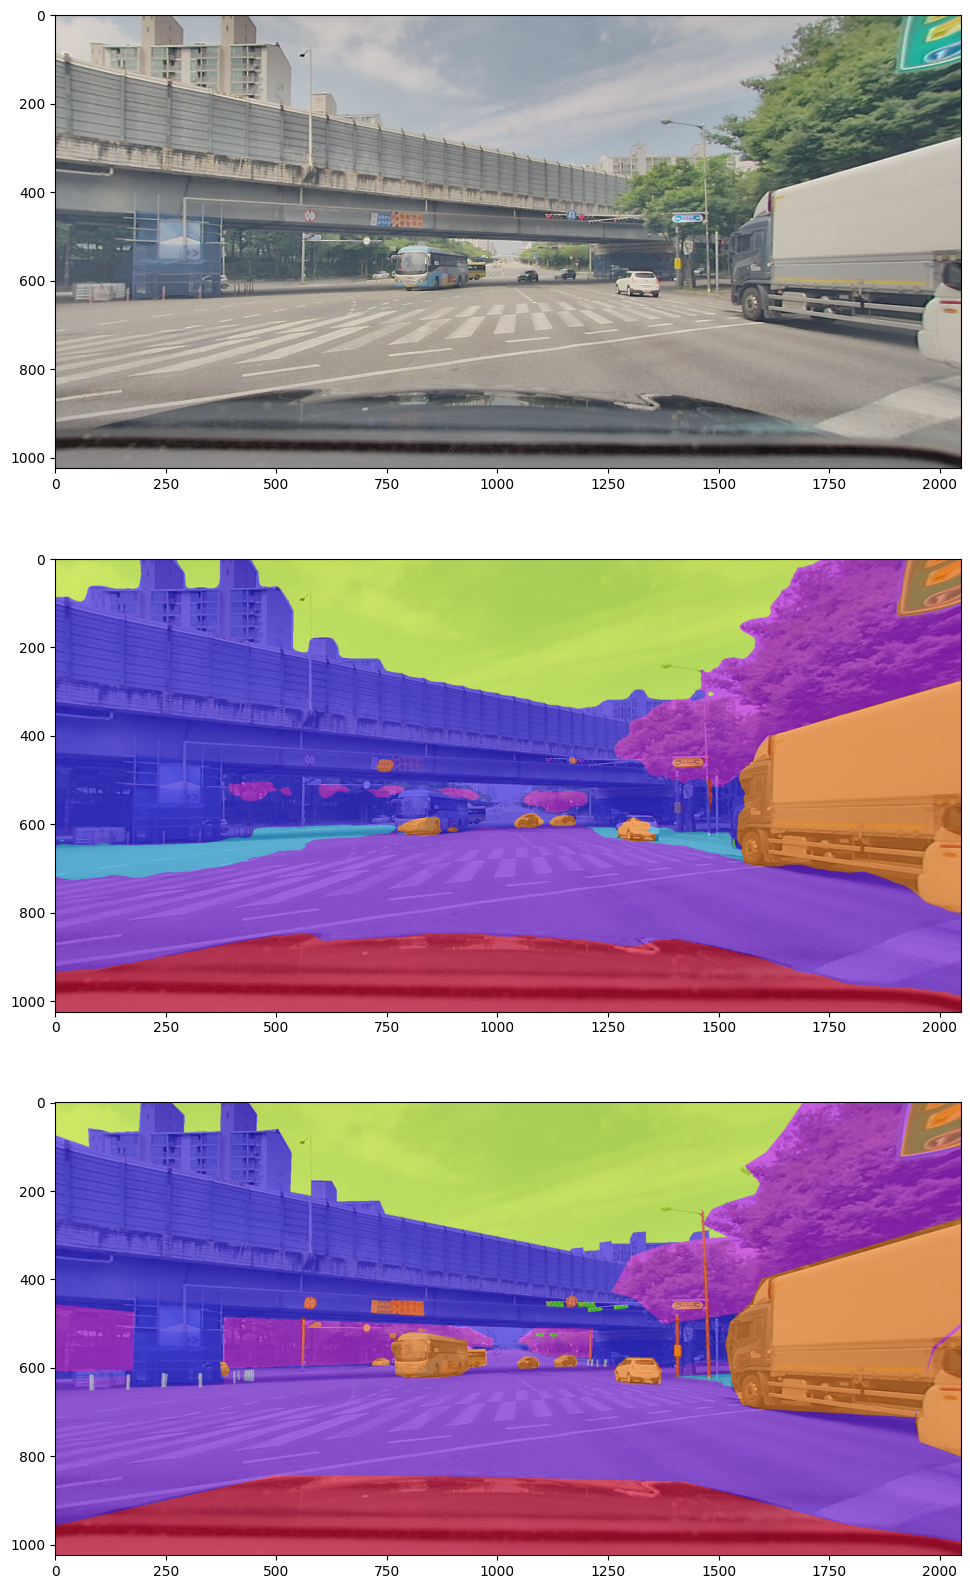

Epoch: 1


  0%|          | 0/632 [00:00<?, ?it/s]

Loss: 0.9567498595793665


KeyboardInterrupt: 

In [63]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# del model
model.to(device)

# # 논문에서는 0.0001 ,wd =  0.05 사용
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5,weight_decay=0.05)
# model_start_idx = int(model_name.split('_')[2])+1
running_loss = 0.0
num_samples = 0
accumulation_steps = 10 # 16
total_batch=  len(train_dataloader)
error_count= 0
for epoch in range(30): # 20->50->5
  
  print("Epoch:", epoch)
  model.train()
  avg_cost = 0
  # model.zero_grad()   
  for idx in tqdm(range(len(train_dataloader))):
    try:
        batch = next(iter(train_dataloader))
    except Exception as e:
        print(e)
        error_count +=1
        # batch = next(iter(train_dataloader))
        pass
    # Reset the parameter gradients
    optimizer.zero_grad()
    # Forward pass
    outputs = model(
        pixel_values=batch["pixel_values"].to(device),
        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
        class_labels=[labels.to(device) for labels in batch["class_labels"]]
    )
    # Backward propagation
    loss = outputs.loss
    loss = loss/accumulation_steps
    loss.backward()
    batch_size = batch["pixel_values"].size(0)
    running_loss += loss.item()
    num_samples += batch_size
    if (idx+1)%accumulation_steps==0:
      optimizer.step()
      model.zero_grad()
      avg_cost += loss / total_batch
    if idx % 100 == 0:
      print("Loss:", running_loss/num_samples)
  print(f'[Epoch:{epoch}] cost = {avg_cost}')
      # Optimization
  model.save_pretrained('new')
  model.eval()
  # model.zero_grad() 
  for idx in tqdm(range(len(test_dataloader))):
    try:
        batch = next(iter(test_dataloader))
    except Exception as e:
        print(e)
        error_count +=1
        # batch = next(iter(test_dataloader))
        pass
    pixel_values = batch["pixel_values"]

    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)
    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]
    
    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
    if idx > 50:
      break
  current = metric.compute(num_labels = len(id2label),ignore_index=0,reduce_labels=False)
  if before_miou==None: 
    before_miou = current['mean_iou']
  else:
    if current['mean_iou'] >= before_miou:
      model.save_pretrained('best_model_base3')
      before_miou = current['mean_iou']
    else:
      model.save_pretrained('last_epoch3')
  print("Mean IoU :", current['mean_iou'])
  print('Mean Acc :',current['mean_accuracy'])
  print('Per Categoric Iou : ',current['per_category_iou'])
  try:
    checking(batch,predicted_segmentation_maps)
  except Exception as e:
    # print(e)
    pass
 

## Define Model

In [ ]:
# import gc
from tqdm.auto import tqdm
for i in tqdm(range(20)):
    pass

# Mask2Former

## Model Train

## Inference

In [ ]:
# preprocessor.size = {
#     "height": 512,
#     "width": 1024
# }

In [ ]:
def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    original_images = inputs[1]
    
    batch = preprocessor.preprocess(
        images,
        ignore_index = 255,
        return_tensors="pt",
    )
    batch["original_images"] = original_images
    return batch


In [ ]:
# 768 ,450 =? 1534,900
sub_transform = A.Compose([
    ToTensorV2(),
])

In [ ]:
sub_glob= glob('./test_image/*.png')
sub_glob.sort()
sub_dataset = CustomDataset(sub_glob, [], transform=sub_transform, infer=True)
print(len(sub_dataset))
sub_dataloader = DataLoader(sub_dataset, batch_size=4, shuffle=False,collate_fn=collate_fn)
len(sub_dataloader)

In [ ]:
sub_glob[:5]

In [ ]:
batch = next(iter(sub_dataloader))
model.to(device)
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

# model.to(device)
with torch.no_grad():
  outputs = model(batch['pixel_values'].to(device))
  # outputs = model(batch)
original_images = batch['original_images']
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

In [ ]:
from torchvision.transforms.functional import to_pil_image
unnormalized_image = (batch['pixel_values'][0].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
deimage = Image.fromarray(unnormalized_image)
deimage

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = predicted_segmentation_maps[0].cpu().numpy()

plt.imshow(segmentation_map)
label_set = {x:id2label_check[x] for x in np.unique(segmentation_map)}
print(label_set)
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
    try:
      print(id2label[label], ' :=>  ',color)
    except:
      # print('pass')
      pass
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]
print(np.unique(segmentation_map))

img = batch['original_images'][0]* 0.8 + ground_truth_color_seg * 0.1
img = ground_truth_color_seg * 0.5 +batch['original_images'][0]* 0.5 
img = ground_truth_color_seg
img = img.astype(np.uint8)
to_pil_image(img)

## Maskformer Model Eval

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

model.eval()
result = []
fig = plt.figure()
rows = 15
cols = 15
i = 1
for idx, batch in enumerate(tqdm(sub_dataloader)):

  # print(batch.shape)
  pixel_values = batch['pixel_values']

  # Forward pass
  with torch.no_grad():
    outputs = model(pixel_values=pixel_values.to(device))
    
  # get original images 
    original_images = batch['original_images']
    # print("Batch : ",batch['pixel_values'].shape)
    # plt.imshow(original_images[0].permute(1,2,0))
    # print("Origin ",original_images[0].shape)
    # mask_valid = make_mask_circle(original_images[0])
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,target_sizes=target_sizes)
    j = 0
    for pred in predicted_segmentation_maps:
        pred = pred.cpu().numpy()
        # pred = cv2.copyTo(pred,mask_valid)
        pred = pred.astype(np.uint8)
        # if i<50:
        #     ax = fig.add_subplot(rows, cols, i)
        #     ax.imshow(original_images[j]*0.5+ pred*0.5)
        #     i+=1
        pred = Image.fromarray(pred) # 이미지로 변환
        pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
        pred = np.array(pred) # 다시 수치로 변환
        
        # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
        for class_id in range(1,13):
            class_mask = (pred == class_id).astype(np.uint8)
            if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                mask_rle = rle_encode(class_mask)
                result.append(mask_rle)
            else: # 마스크가 존재하지 않는 경우 -1
                result.append(-1)


## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result
submit

In [ ]:
submit.to_csv('./baseline_submit.csv', index=False)

In [ ]:
# cp baseline_submit.csv content/drive/MyDrive/